## Preamble

### Imports

In [244]:
import asyncio
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection as skm
from sklearn.tree import \
    DecisionTreeClassifier as DTC, \
    DecisionTreeRegressor as DTR, \
    plot_tree, export_text
from sklearn.metrics import accuracy_score, \
    log_loss, mean_squared_error, confusion_matrix, \
    classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import \
    RandomForestRegressor as RF, \
    GradientBoostingRegressor as GBR, \
    GradientBoostingClassifier as GBC
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART

## Boston

In [2]:
Boston = load_data('Boston')
Boston.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
lstat      float64
medv       float64
dtype: object

### Train/test split

In [3]:
X = Boston.drop('medv', axis='columns')
y = Boston.loc[:, 'medv']
features = X.columns.tolist()
X.shape, y.shape, len(features)

((506, 12), (506,), 12)

In [4]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 12), (152, 12), (354,), (152,))

### Random forest models

We fit $3*401$ random forest models which will take some time, so we use async/await pattern to 
improve runtime.

In [5]:
async def get_boston_rf_test_mse(n_estimators, max_features):
    model = RF(
        n_estimators=n_estimators, 
        max_features=max_features, 
        random_state=0, 
        n_jobs=-1,
    )
    model.fit(X_train, y_train)

    y_hat = model.predict(X_test)
    return mean_squared_error(y_test, y_hat)

async def get_boston_rf_test_mse_wrapper(i, j, n, m):
    mse = await get_boston_rf_test_mse(n, m)
    print('.', end='')
    return i, j, mse
    
async def boston_fit_rf_models(n_estimators, m_features):
    tasks = []    
    for (i, m) in enumerate(m_features):
        for (j, n) in enumerate(n_estimators):
            tasks.append(asyncio.create_task(get_boston_rf_test_mse_wrapper(i, j, n, m)))
    results = await asyncio.gather(*tasks)

    # save the results
    mses = np.zeros(len(n_estimators)*3).reshape((3, len(n_estimators)))
    for i, j, mse in results:
        mses[i, j] = mse

    return mses

In [6]:
m_features = [len(features), len(features)//2, 'sqrt'];
n_estimators = np.arange(100, 501)

start_time = time.time()
rf_mses = await boston_fit_rf_models(n_estimators, m_features)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time:.4f} seconds")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### MSE plot

We show the MSE curve for different `n_estimators`.

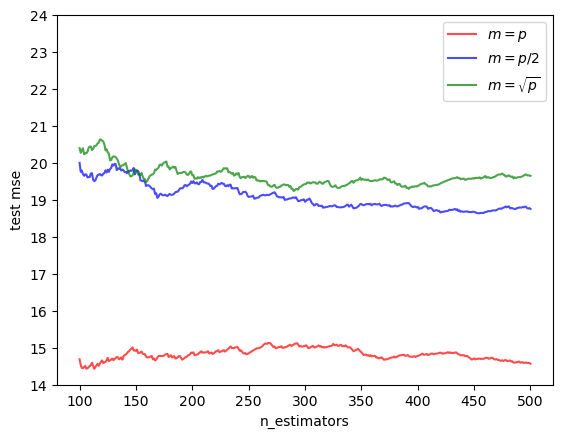

In [7]:
_, ax = plt.subplots()

mse_plot_params = [
    ('$m=p$', 'r'),
    ('$m=p/2$', 'b'),
    (r'$m=\sqrt{p}$', 'g'),
]

for i, (label, c) in enumerate(mse_plot_params):
    ax.plot(n_estimators, rf_mses[i], c=c, label=label, alpha=.7)

ax.set_ylabel('test mse')
ax.set_xlabel('n_estimators')
ax.set_yticks(np.arange(14, 25))
ax.legend();

In my experience, $m=\sqrt{p}$ usually performs well, but in this dataset, $m=p$ has the lowest test MSE.

## Carseats

In [8]:
Carseats = load_data('Carseats')
Carseats.dtypes

Sales           float64
CompPrice         int64
Income            int64
Advertising       int64
Population        int64
Price             int64
ShelveLoc      category
Age               int64
Education         int64
Urban          category
US             category
dtype: object

### Train/test split

In [9]:
target = 'Sales'
X = Carseats.drop(target, axis='columns')
y = Carseats.loc[:, target]
features = X.columns.tolist()
X.shape, y.shape, len(features)

((400, 10), (400,), 10)

In [10]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((280, 10), (120, 10), (280,), (120,))

### Regression tree

#### ISLP style

In [11]:
ms = MS(Carseats.columns.drop(target), intercept=False)

feature_names = ms.fit_transform(X_train).columns.tolist()

reg = DTR(max_depth=3, random_state=0)
reg.fit(ms.fit_transform(X_train), y_train)

y_hat = reg.predict(ms.fit_transform(X_test))
mean_squared_error(y_test, y_hat)

3.7038582752360942

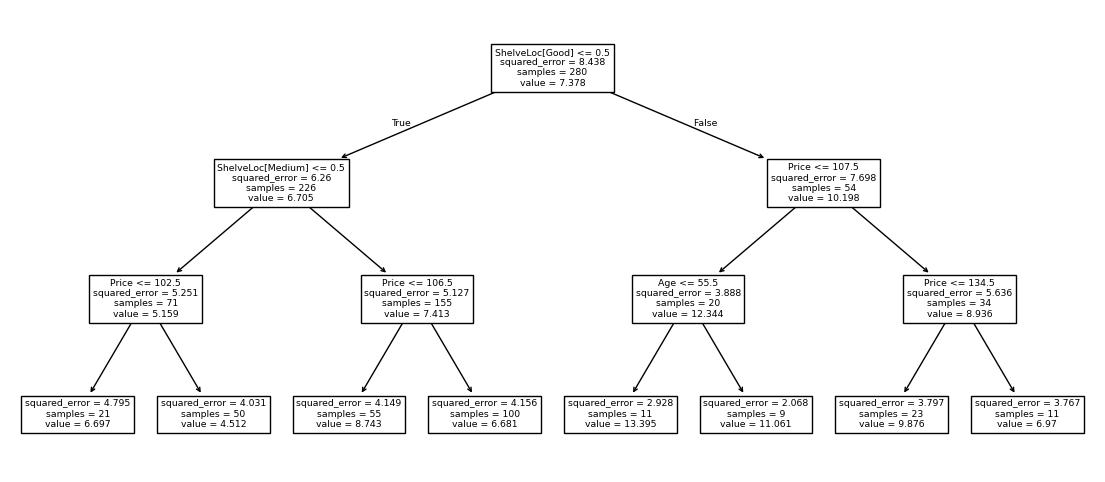

In [12]:
_, ax = plt.subplots(figsize=(14, 6))

plot_tree(
    reg, 
    feature_names=feature_names, 
    ax=ax,
);

#### sklearn style

In [13]:
cat_features = [x for x in X.columns if X[x].dtype == 'category']
num_features = [x for x in X.columns if x not in cat_features]
cat_features, num_features

(['ShelveLoc', 'Urban', 'US'],
 ['CompPrice',
  'Income',
  'Advertising',
  'Population',
  'Price',
  'Age',
  'Education'])

In [14]:
ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', 'passthrough', num_features)
])

carseats_model = Pipeline([
    ('ct', ct),
    ('reg', DTR(max_depth=3, random_state=0)),
])
carseats_model.fit(X_train, y_train)

y_hat = carseats_model.predict(X_test)
mean_squared_error(y_test, y_hat)

3.703858275236094

In [15]:
carseats_model.named_steps['ct'].named_transformers_['cat'].get_feature_names_out(cat_features).tolist()

['ShelveLoc_Bad',
 'ShelveLoc_Good',
 'ShelveLoc_Medium',
 'Urban_No',
 'Urban_Yes',
 'US_No',
 'US_Yes']

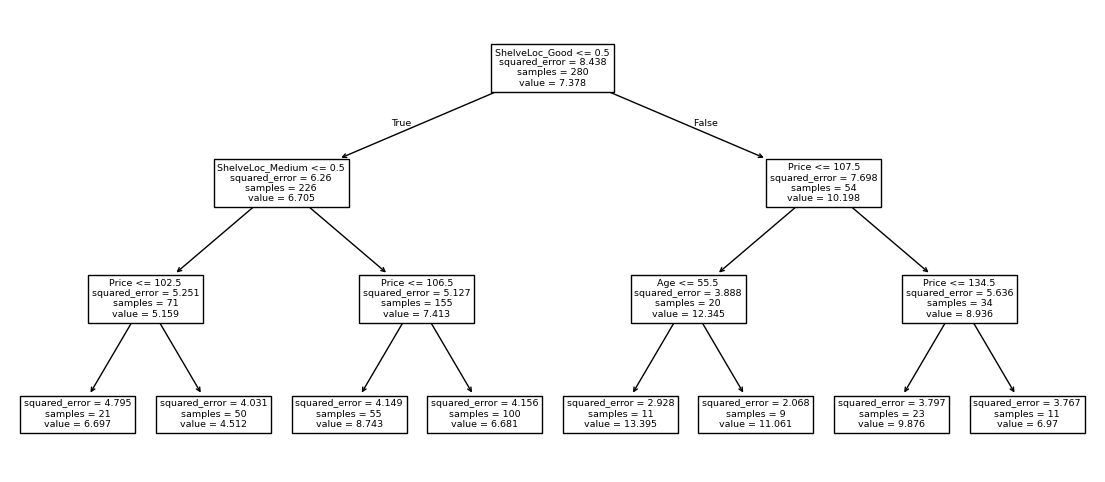

In [16]:
_, ax = plt.subplots(figsize=(14, 6))

carseats_reg = carseats_model.named_steps['reg']
# mouthful I know!
feature_names = carseats_model.named_steps['ct'].\
    named_transformers_['cat'].\
    get_feature_names_out(cat_features).\
    tolist() + num_features

plot_tree(
    carseats_reg, 
    feature_names=feature_names, 
    ax=ax,
);

### Cross-validation

In [17]:
cv = skm.ShuffleSplit(n_splits=5, test_size=.33, random_state=0)
results = skm.cross_validate(carseats_model, X, y, cv=cv, return_train_score=True)
results['test_score'].mean(), results['train_score'].mean()

(0.3982585227489213, 0.5284835727849756)

### Pruning

In [18]:
reg = carseats_model.named_steps['reg']
ct = carseats_model.named_steps['ct']
ccp_path = carseats_reg.cost_complexity_pruning_path(ct.fit_transform(X_train), y_train)

param_grid = {'reg__ccp_alpha': ccp_path.ccp_alphas}
grid = skm.GridSearchCV(
    carseats_model,
    param_grid=param_grid,
    refit=True,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

(-5.567725368688545, {'reg__ccp_alpha': 0.0})

In [19]:
y_hat = grid.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_hat)

3.703858275236094

The MSE from the grid search indicates that pruning offers no improvement.

### Random Forest

In [20]:
carseats_bagged = Pipeline([
    ('ct', ct),
    ('reg', RF(max_depth=3, random_state=0, n_jobs=-1)),
])
carseats_bagged.fit(X_train, y_train)

y_hat = carseats_bagged.predict(X_test)
mean_squared_error(y_test, y_hat)

2.990836895794092

### Feature importance

In [21]:
carseats_reg = carseats_model.named_steps['reg']

feature_importance = pd.DataFrame({
    'importance': carseats_reg.feature_importances_,
}, index=feature_names).sort_values(by='importance')
feature_importance = feature_importance.loc[feature_importance['importance'] > 0]
feature_importance.shape

(4, 1)

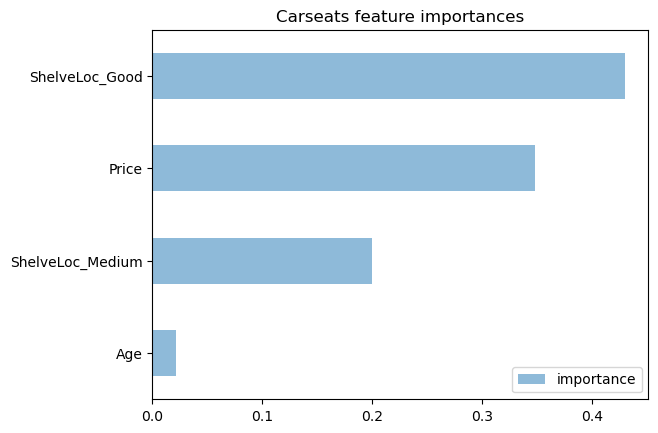

In [22]:
_, ax = plt.subplots()

feature_importance.plot(kind='barh', ax=ax, alpha=.5)

ax.set_title('Carseats feature importances')
ax.legend(loc='lower right');

### BART

Todo

## OJ

In [100]:
OJ = load_data('OJ')
OJ

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


### Train/test split

In [101]:
target = 'Purchase'
X = OJ.drop(target, axis='columns')
y = OJ.loc[:, target]
features = X.columns.tolist()
X.shape, y.shape, len(features)

((1070, 17), (1070,), 17)

In [102]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=800, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 17), (270, 17), (800,), (270,))

### Classification tree

In [103]:
cat_features = [x for x in X.columns if X[x].dtype == 'category']
num_features = [x for x in X.columns if x not in cat_features]
cat_features, num_features

(['Store7'],
 ['WeekofPurchase',
  'StoreID',
  'PriceCH',
  'PriceMM',
  'DiscCH',
  'DiscMM',
  'SpecialCH',
  'SpecialMM',
  'LoyalCH',
  'SalePriceMM',
  'SalePriceCH',
  'PriceDiff',
  'PctDiscMM',
  'PctDiscCH',
  'ListPriceDiff',
  'STORE'])

In [104]:
ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', 'passthrough', num_features)
])

oj_model = Pipeline([
    ('ct', ct),
    ('clf', DTC(max_depth=3, random_state=0)),
])
oj_model.fit(X_train, y_train)

accuracy_score(y_train, oj_model.predict(X_train))

0.8225

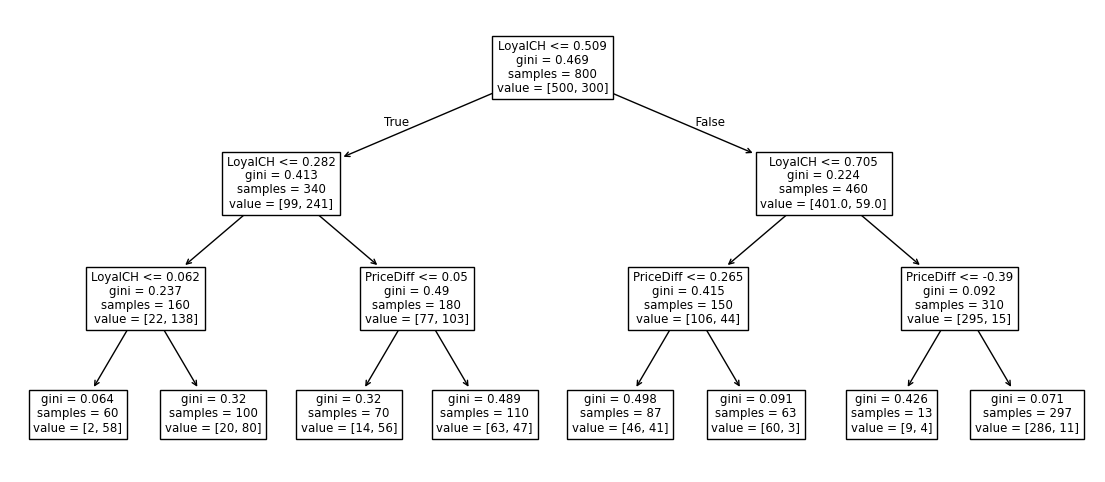

In [105]:
_, ax = plt.subplots(figsize=(14, 6))

oj_clf = oj_model.named_steps['clf']
feature_names = oj_model.named_steps['ct'].\
    named_transformers_['cat'].\
    get_feature_names_out(cat_features).\
    tolist() + num_features

plot_tree(
    oj_clf, 
    feature_names=feature_names, 
    ax=ax,
);

In [106]:
print(export_text(oj_clf, feature_names=feature_names, show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- weights: [2.00, 58.00] class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- weights: [20.00, 80.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [14.00, 56.00] class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [63.00, 47.00] class: CH
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- weights: [46.00, 41.00] class: CH
|   |   |--- PriceDiff >  0.27
|   |   |   |--- weights: [60.00, 3.00] class: CH
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- weights: [9.00, 4.00] class: CH
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- weights: [286.00, 11.00] class: CH



### Confusion matrix

Test error estimate.

In [107]:
y_hat = oj_model.predict(X_test)
accuracy_score(y_test, y_hat)

0.8111111111111111

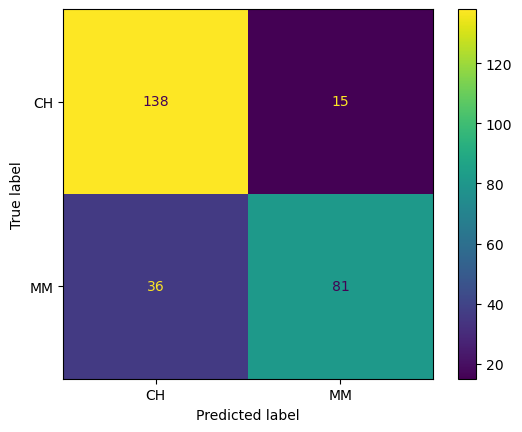

In [108]:
cm = confusion_matrix(
    y_test, y_hat, 
    labels=oj_clf.classes_
)

cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=oj_clf.classes_,
)

_, ax = plt.subplots()
cm_disp.plot(ax=ax);

### Best tree depth

In [109]:
depths = np.arange(3, 15)
test_scores = np.zeros(len(depths))

for i, depth in enumerate(depths):
    model = Pipeline([
        ('ct', ct),
        ('clf', DTC(max_depth=depth, random_state=0)),
    ])
    
    results = skm.cross_validate(model, X_train, y_train, cv=5)
    test_scores[i] = results['test_score'].mean()


In [110]:
max_score =  test_scores.max()
depths[np.where(test_scores == max_score)], max_score

(array([7]), 0.79375)

The results from cross-validation indicates that the best tree depth is `7`, with an accuracy score of `79.38`.

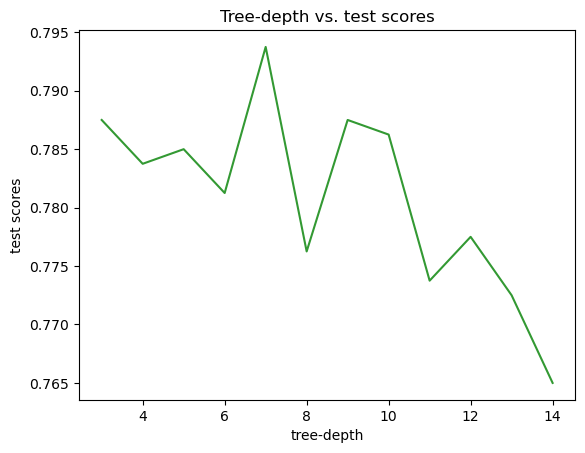

In [111]:
_, ax = plt.subplots()
ax.plot(depths, test_scores, c='g', alpha=.8)
ax.set_title('Tree-depth vs. test scores')
ax.set_ylabel('test scores')
ax.set_xlabel('tree-depth');

### Pruning

In [112]:
oj_clf_tuned = DTC(max_depth=7, random_state=0)
oj_model_pruned = Pipeline([
    ('ct', ct),
    ('clf', oj_clf_tuned),
])

ccp_path = oj_clf_tuned.cost_complexity_pruning_path(ct.fit_transform(X_train), y_train)

param_grid = {'clf__ccp_alpha': ccp_path.ccp_alphas}
grid = skm.GridSearchCV(
    oj_model_pruned,
    param_grid=param_grid,
    refit=True,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.8025, {'clf__ccp_alpha': 0.0036257363253856915})

In [113]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

0.7777777777777778

As can be observed, the classifier with `max_depth=3` outperformed the one with `max_depth=7`, most likely overfitted the data.

## Hitters

In [114]:
Hitters = load_data('Hitters')
Hitters.shape

(322, 20)

In [115]:
Hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [116]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

### Train/test split

In [117]:
target = 'Salary'
X = Hitters.drop(target, axis='columns')
y = Hitters.loc[:, target]
X.shape, y.shape

((263, 19), (263,))

In [118]:
features = X.columns.tolist()
', '.join(features)

'AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks, League, Division, PutOuts, Assists, Errors, NewLeague'

In [119]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=200, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200, 19), (63, 19), (200,), (63,))

In [120]:
X.dtypes

AtBat           int64
Hits            int64
HmRun           int64
Runs            int64
RBI             int64
Walks           int64
Years           int64
CAtBat          int64
CHits           int64
CHmRun          int64
CRuns           int64
CRBI            int64
CWalks          int64
League       category
Division     category
PutOuts         int64
Assists         int64
Errors          int64
NewLeague    category
dtype: object

### Boosting

In [121]:
cat_features = [x for x in X.columns if X[x].dtype == 'category']
num_features = [x for x in X.columns if x not in cat_features]
', '.join(cat_features), ', '.join(num_features)

('League, Division, NewLeague',
 'AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks, PutOuts, Assists, Errors')

In [151]:
ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', 'passthrough', num_features)
])

hitters_model = Pipeline([
    ('ct', ct),
    ('reg', GBR(n_estimators=1000, random_state=0, n_jobs=-1)),
])

cv_results = skm.cross_validate(
    hitters_model, 
    X_train, y_train, 
    scoring='neg_mean_squared_error',
    return_train_score=True, 
    cv=5
)
-cv_results['test_score'].mean(), -cv_results['train_score'].mean()

(88421.63881816866, 8.244047289074913e-05)

### Learning rates

In [152]:
alphas = np.linspace(0.0001, 0.1)
alphas

array([0.0001    , 0.00213878, 0.00417755, 0.00621633, 0.0082551 ,
       0.01029388, 0.01233265, 0.01437143, 0.0164102 , 0.01844898,
       0.02048776, 0.02252653, 0.02456531, 0.02660408, 0.02864286,
       0.03068163, 0.03272041, 0.03475918, 0.03679796, 0.03883673,
       0.04087551, 0.04291429, 0.04495306, 0.04699184, 0.04903061,
       0.05106939, 0.05310816, 0.05514694, 0.05718571, 0.05922449,
       0.06126327, 0.06330204, 0.06534082, 0.06737959, 0.06941837,
       0.07145714, 0.07349592, 0.07553469, 0.07757347, 0.07961224,
       0.08165102, 0.0836898 , 0.08572857, 0.08776735, 0.08980612,
       0.0918449 , 0.09388367, 0.09592245, 0.09796122, 0.1       ])

#### Train MSE

In [154]:
train_mses = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    model = Pipeline([
        ('ct', ct),
        ('reg', GBR(
            learning_rate=alpha,
            n_estimators=1000, 
            random_state=0,
            n_jobs=-1,
        )),
    ])
    
    model.fit(X_train, y_train)
    train_mses[i] = mean_squared_error(y_train, model.predict(X_train))
    print('.', end='')

..................................................

In [155]:
min_train_mse =  train_mses.min()
alphas[np.where(train_mses == min_train_mse)], min_train_mse

(array([0.09796122]), 0.001521217014476809)

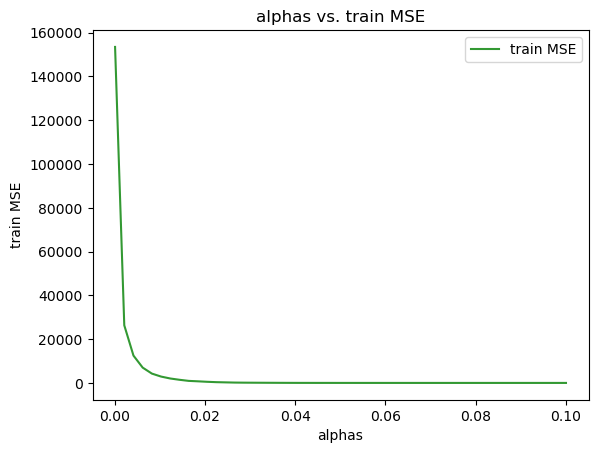

In [156]:
_, ax = plt.subplots()
ax.plot(alphas, train_mses, c='g', alpha=.8, label='train MSE')
ax.set_title('alphas vs. train MSE')
ax.set_ylabel('train MSE')
ax.set_xlabel('alphas')
ax.legend();

The train MSE has a steep drop around `0.01`.

#### Test MSE

In [157]:
test_mses = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    model = Pipeline([
        ('ct', ct),
        ('reg', GBR(
            learning_rate=alpha,
            n_estimators=1000, 
            random_state=0,
            n_jobs=-1,
        )),
    ])
    
    model.fit(X_train, y_train)
    test_mses[i] = mean_squared_error(y_test, model.predict(X_test))
    print('.', end='')

..................................................

In [158]:
min_test_mse =  test_mses.min()
alphas[np.where(test_mses == min_test_mse)], min_test_mse

(array([0.07553469]), 109025.97365570412)

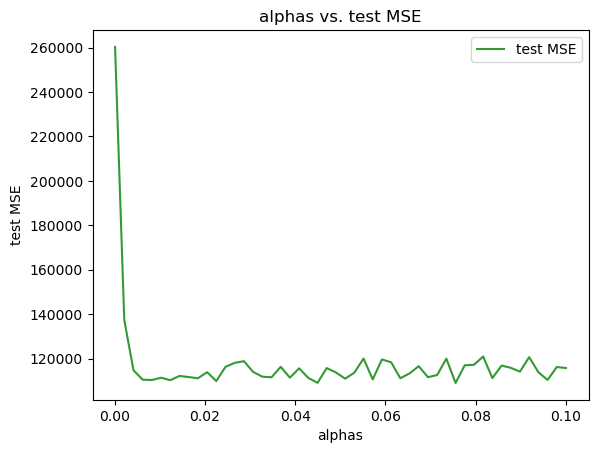

In [159]:
_, ax = plt.subplots()
ax.plot(alphas, test_mses, c='g', alpha=.8, label='test MSE')
ax.set_title('alphas vs. test MSE')
ax.set_ylabel('test MSE')
ax.set_xlabel('alphas')
ax.legend();

The test MSE has a steep drop on `0.01`, but beyond `0.01`, the test MSE looks jagged, but hovers around `100,000` to `110,000`.

### Feature importances

In [161]:
tuned_hitters_model = Pipeline([
    ('ct', ct),
    ('reg', GBR(
        n_estimators=1000,
        learning_rate=0.07553469,
        random_state=0,
        n_jobs=-1,
    )),
])
tuned_hitters_model.fit(X_train, y_train)

mean_squared_error(y_test, tuned_hitters_model.predict(X_test))

110984.16055019463

In [165]:
hitters_reg = tuned_hitters_model.named_steps['reg']

feature_names = hitters_model.named_steps['ct'].\
    named_transformers_['cat'].\
    get_feature_names_out(cat_features).\
    tolist() + num_features

feature_importance = pd.DataFrame({
    'importance': hitters_reg.feature_importances_,
}, index=feature_names).sort_values(by='importance')
feature_importance = feature_importance.loc[feature_importance['importance'] > 0]
feature_importance.shape

(22, 1)

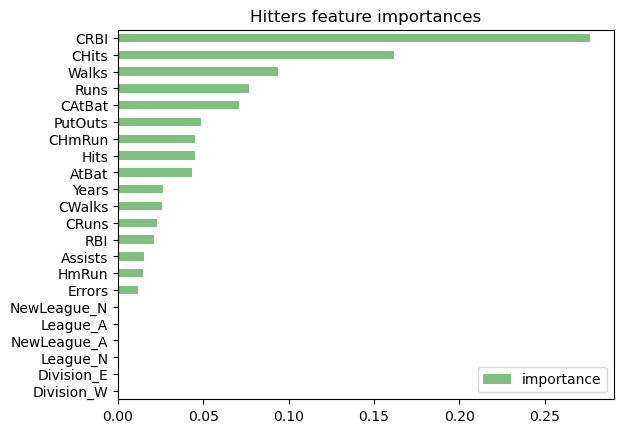

In [168]:
_, ax = plt.subplots()

feature_importance.plot(kind='barh', ax=ax, color='g', alpha=.5)

ax.set_title('Hitters feature importances')
ax.legend(loc='lower right');

The plot indicates that the `CRBI` or the _Number of runs batted in during his career_ is the most important feature in this data set according to the model.

### Comparison with bagging

In [171]:
hitters_bagged = Pipeline([
    ('ct', ct),
    ('reg', RF(
        n_estimators=1000,
        random_state=0,
        n_jobs=-1,
    )),
])
hitters_bagged.fit(X_train, y_train)

mean_squared_error(y_test, hitters_bagged.predict(X_test))

110706.81919671055

The bagged model has a similar performance with the boosted model.

## Caravan

In [194]:
Caravan = load_data('Caravan')
Caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


### Train/test split

In [189]:
target = 'Purchase'
X = Caravan.drop(target, axis='columns')
y = Caravan.loc[:, target]
X.shape, y.shape

((5822, 85), (5822,))

In [190]:
features = X.columns.tolist()
', '.join(features)

'MOSTYPE, MAANTHUI, MGEMOMV, MGEMLEEF, MOSHOOFD, MGODRK, MGODPR, MGODOV, MGODGE, MRELGE, MRELSA, MRELOV, MFALLEEN, MFGEKIND, MFWEKIND, MOPLHOOG, MOPLMIDD, MOPLLAAG, MBERHOOG, MBERZELF, MBERBOER, MBERMIDD, MBERARBG, MBERARBO, MSKA, MSKB1, MSKB2, MSKC, MSKD, MHHUUR, MHKOOP, MAUT1, MAUT2, MAUT0, MZFONDS, MZPART, MINKM30, MINK3045, MINK4575, MINK7512, MINK123M, MINKGEM, MKOOPKLA, PWAPART, PWABEDR, PWALAND, PPERSAUT, PBESAUT, PMOTSCO, PVRAAUT, PAANHANG, PTRACTOR, PWERKT, PBROM, PLEVEN, PPERSONG, PGEZONG, PWAOREG, PBRAND, PZEILPL, PPLEZIER, PFIETS, PINBOED, PBYSTAND, AWAPART, AWABEDR, AWALAND, APERSAUT, ABESAUT, AMOTSCO, AVRAAUT, AAANHANG, ATRACTOR, AWERKT, ABROM, ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, AZEILPL, APLEZIER, AFIETS, AINBOED, ABYSTAND'

In [191]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=1000, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4822, 85), (1000, 85), (4822,), (1000,))

### Boosting

In [185]:
cat_features = [x for x in X.columns if X[x].dtype == 'category']
num_features = [x for x in X.columns if x not in cat_features]
', '.join(cat_features), ', '.join(num_features)

('',
 'MOSTYPE, MAANTHUI, MGEMOMV, MGEMLEEF, MOSHOOFD, MGODRK, MGODPR, MGODOV, MGODGE, MRELGE, MRELSA, MRELOV, MFALLEEN, MFGEKIND, MFWEKIND, MOPLHOOG, MOPLMIDD, MOPLLAAG, MBERHOOG, MBERZELF, MBERBOER, MBERMIDD, MBERARBG, MBERARBO, MSKA, MSKB1, MSKB2, MSKC, MSKD, MHHUUR, MHKOOP, MAUT1, MAUT2, MAUT0, MZFONDS, MZPART, MINKM30, MINK3045, MINK4575, MINK7512, MINK123M, MINKGEM, MKOOPKLA, PWAPART, PWABEDR, PWALAND, PPERSAUT, PBESAUT, PMOTSCO, PVRAAUT, PAANHANG, PTRACTOR, PWERKT, PBROM, PLEVEN, PPERSONG, PGEZONG, PWAOREG, PBRAND, PZEILPL, PPLEZIER, PFIETS, PINBOED, PBYSTAND, AWAPART, AWABEDR, AWALAND, APERSAUT, ABESAUT, AMOTSCO, AVRAAUT, AAANHANG, ATRACTOR, AWERKT, ABROM, ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, AZEILPL, APLEZIER, AFIETS, AINBOED, ABYSTAND')

There are only numerical features.

In [207]:
caravan_model = Pipeline([
    ('clf', GBC(
        learning_rate=0.01,
        n_estimators=1000, 
        random_state=0,
    )),
])

caravan_model.fit(X_train, y_train)

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1


### Cross-validation

In [209]:
cv_results = skm.cross_validate(
    caravan_model, 
    X_train, y_train, 
    return_train_score=True, 
    cv=5, n_jobs=-1,
    verbose=1,
)

cv_results['test_score'].mean(), cv_results['train_score'].mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished


(0.9398593941478728, 0.949865197664618)

### Feature importance

In [210]:
caravan_clf = caravan_model.named_steps['clf']

feature_names = num_features

feature_importance = pd.DataFrame({
    'importance': caravan_clf.feature_importances_,
}, index=feature_names).sort_values(by='importance')
feature_importance = feature_importance.loc[feature_importance['importance'] > 0]
feature_importance.shape

(72, 1)

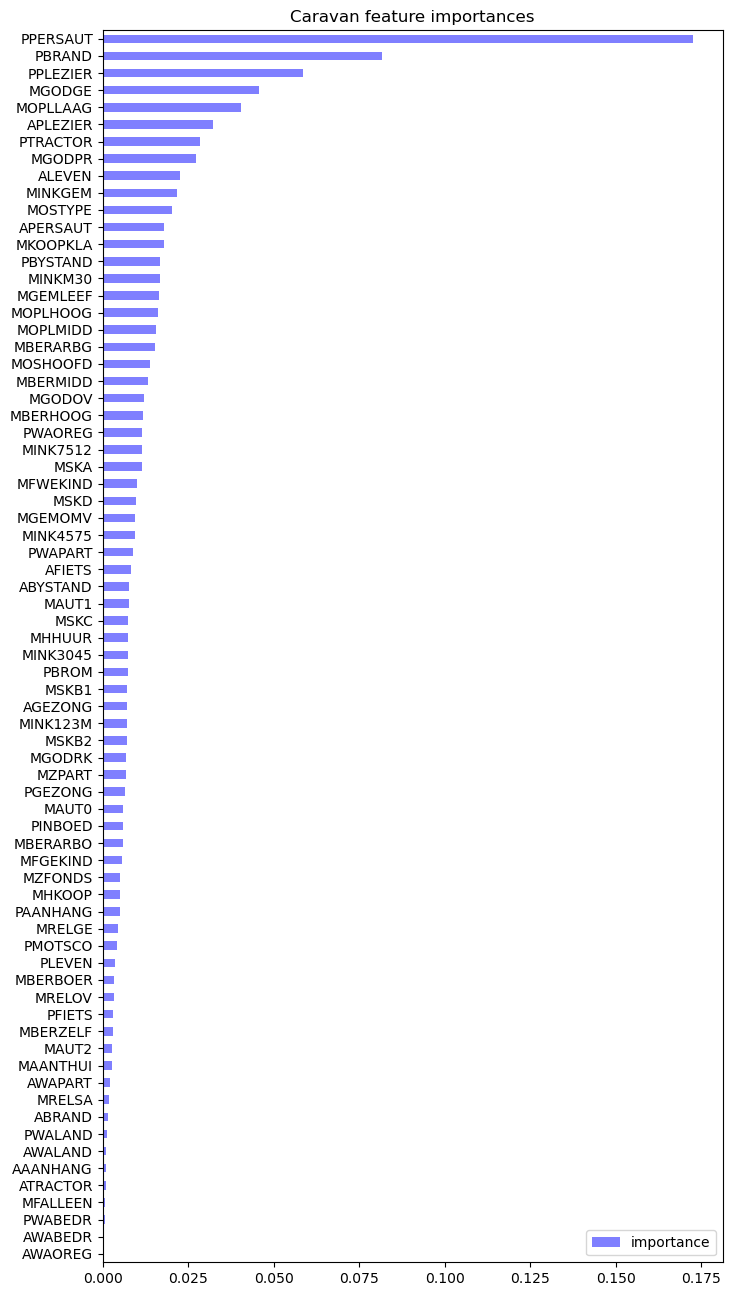

In [216]:
_, ax = plt.subplots(figsize=(8, 16))

feature_importance.plot(kind='barh', ax=ax, color='b', alpha=.5)

ax.set_title('Caravan feature importances')
ax.legend(loc='lower right');

The plot indicates that `PPERSAUT` or _Contribution car policies_ is the most important feature.

### Test predictions

In [218]:
caravan_model.classes_

array(['No', 'Yes'], dtype=object)

In [225]:
y_proba = caravan_model.predict_proba(X_test)
y_hat = np.where(y_proba[:, 1] > .2, 'Yes', 'No')
accuracy_score(y_test, y_hat)

0.915

### Confusion matrix

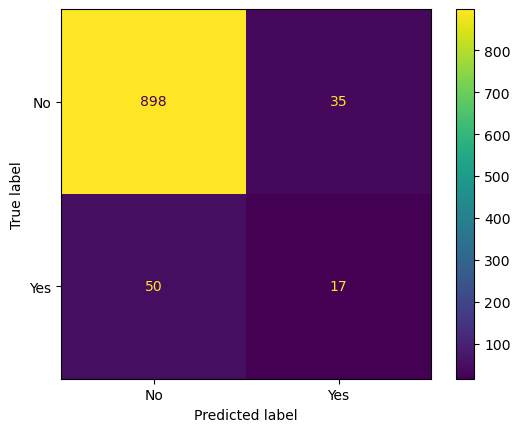

In [236]:
cm = confusion_matrix(
    y_test, y_hat, 
    labels=caravan_model.classes_
)

cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=caravan_model.classes_,
)

_, ax = plt.subplots()
cm_disp.plot(ax=ax);

In [247]:
print(classification_report(y_test, y_hat, target_names=caravan_model.classes_))

              precision    recall  f1-score   support

          No       0.95      0.96      0.95       933
         Yes       0.33      0.25      0.29        67

    accuracy                           0.92      1000
   macro avg       0.64      0.61      0.62      1000
weighted avg       0.91      0.92      0.91      1000

